Title

Description

Importing packages.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Importing data into pandas DataFrame.

In [21]:
df = pd.read_csv(r"fullDataFinal.csv", index_col=0)
df.columns = df.columns.str.strip()
df.sample(5)

,fire_size_class,latitude,longitude,discovery_month,weekday,Vegetation,remoteness,elevation,Temp,Wind,Humidity,Precipitation
23454,B,35.368100,-119.503300,Jul,True,Rock,0.491728,88.0,27.008556,2.923989,40.765182,0.000000
19388,B,32.386775,-97.895007,Oct,True,Shrubland,0.281443,301.0,26.511157,1.967762,54.134641,9.800000
16510,B,31.674840,-93.689350,Mar,True,Shrubland,0.242539,88.0,13.040787,2.424651,73.292886,0.000000
14157,C,30.462722,-95.495750,Jan,True,Shrubland,0.260318,103.0,4.797293,1.007193,25.859363,8.766667
27248,B,44.966111,-119.731389,Sep,True,Rock,0.489797,1318.0,20.739504,3.214325,75.707158,0.000000


Separate target variable (fire_size_class) from predictor variables.

In [22]:
dfTarget = df["fire_size_class"]
dfPredictor = df[["latitude", "longitude", "discovery_month", "weekday", "Vegetation", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]

Before doing anything, let's check the distribution of our data by plotting a histogram

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'remoteness'}>],
       [<AxesSubplot:title={'center':'elevation'}>,
        <AxesSubplot:title={'center':'Temp'}>,
        <AxesSubplot:title={'center':'Wind'}>],
       [<AxesSubplot:title={'center':'Humidity'}>,
        <AxesSubplot:title={'center':'Precipitation'}>, <AxesSubplot:>]],
      dtype=object)

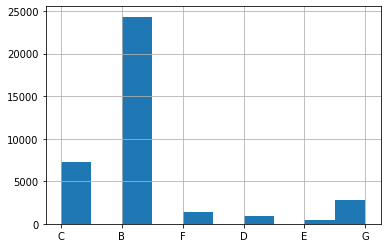

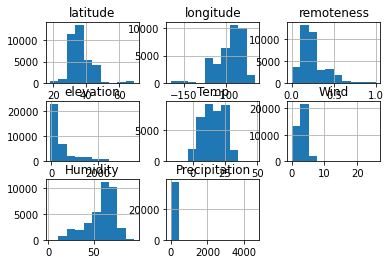

In [23]:
dfTarget.hist()
dfPredictor.hist()

From the first histogram we can see that the "B" class is *way* overrepresented in our data and there is an imbalance.

In order to deal with this, I chose to undersample the B class.



Changing categorical variables into one-hot encoded ones.

In [24]:
# First let's do fire_size_class
dfTarget = pd.concat([dfTarget, pd.get_dummies(dfTarget)], axis=1)  # use get_dummies and concatenate the result to dfTarget
dfTarget.drop(["fire_size_class"], axis=1, inplace=True)  # and remove the old column
dfTarget.sample(5)

,B,C,D,E,F,G
11124,1,0,0,0,0,0
7019,1,0,0,0,0,0
14887,1,0,0,0,0,0
30519,1,0,0,0,0,0
28718,1,0,0,0,0,0


In [25]:
# Now Vegetation
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["Vegetation"], prefix="Veg", prefix_sep=" ")], axis=1)
dfPredictor.drop(["Vegetation"], axis=1, inplace=True)

# And discovery_month
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["discovery_month"])], axis=1)
dfPredictor.drop(["discovery_month"], axis=1, inplace=True)

# And weekday
dfPredictor = pd.concat([dfPredictor, pd.get_dummies(dfPredictor["weekday"])], axis=1)
dfPredictor.drop(["weekday"], axis=1, inplace=True)
dfPredictor.rename(columns={False:"is_weekend", True:"is_weekday"}, inplace=True)
dfPredictor.sample(5)

,latitude,longitude,remoteness,elevation,Temp,Wind,Humidity,Precipitation,Veg Broadleaf Forest,Veg Desert,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,is_weekend,is_weekday
17065,35.428300,-79.041700,0.107525,112.0,11.574698,2.380723,71.045447,17.966667,0,0,...,1,0,0,0,0,0,0,0,1,0
25172,45.451552,-88.130608,0.184499,297.0,11.344736,4.245583,61.286242,0.000000,0,0,...,0,0,0,0,1,0,0,0,1,0
5683,47.496194,-94.929978,0.246764,419.0,6.354496,3.480198,67.006140,0.000000,0,0,...,0,0,0,0,1,0,0,0,1,0
34916,66.911200,-151.502700,0.638436,0.0,19.030951,1.947256,58.718032,8.166667,0,0,...,0,1,0,0,0,0,0,0,0,1
18005,33.191747,-89.947305,0.206901,97.0,8.940829,4.038849,74.016337,52.500000,1,0,...,0,0,0,1,0,0,0,0,0,1


Scaling numerical data to 0-1 range.

In [26]:
from sklearn.preprocessing import MinMaxScaler

dfPredictorScaled = pd.DataFrame(MinMaxScaler().fit_transform(dfPredictor[["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"]]), columns=["latitude", "longitude", "remoteness", "elevation", "Temp", "Wind", "Humidity", "Precipitation"])
# dfPredictorScaled.sample(5)

dfPredictor = dfPredictor.assign(**dfPredictorScaled.to_dict(orient="series"))  # replace the columns of the old df with the ones from the new one
dfPredictor.sample(5)

,latitude,longitude,remoteness,elevation,Temp,Wind,Humidity,Precipitation,Veg Broadleaf Forest,Veg Desert,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,is_weekend,is_weekday
27779,0.296144,0.719524,0.238662,0.040044,0.462267,0.120702,0.772816,0.001428,1,0,...,0,0,0,0,0,0,0,0,0,1
34778,0.426919,0.450922,0.118555,0.463247,0.653532,0.127270,0.266635,0.001363,0,0,...,0,1,0,0,0,0,0,0,1,0
32067,0.311683,0.775125,0.187166,0.053758,0.481797,0.039695,0.760072,0.005952,1,0,...,0,0,0,0,0,1,0,0,1,0
18823,0.412114,0.822716,0.141459,0.063906,0.367292,0.085503,0.655562,0.013572,0,0,...,0,0,0,1,0,0,0,0,0,1
28465,0.548516,0.729771,0.223186,0.097916,0.432352,0.083149,0.681954,0.004053,0,0,...,0,0,0,0,0,0,1,0,0,1


Make a correlation matrix

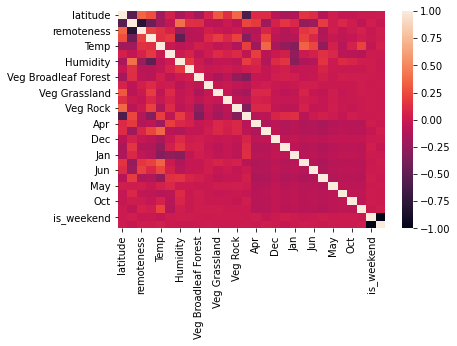

In [28]:
import seaborn as sn

corrMatrix = dfPredictor.corr()
sn.heatmap(corrMatrix)
plt.show()

Train-test split

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfPredictor, dfTarget, test_size=0.1, random_state=42)

print(X_train.shape)
print(y_train.shape)

(33522, 28)
(33522, 6)


In [30]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train.values)

print(X_train.shape)
print(y_train.shape)

y_train = pd.DataFrame(y_train)

(2646, 28)
(2646, 6)


d:\pycharmprojects\thesis\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>]], dtype=object)

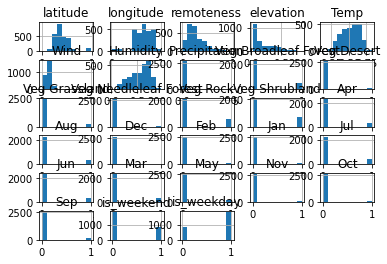

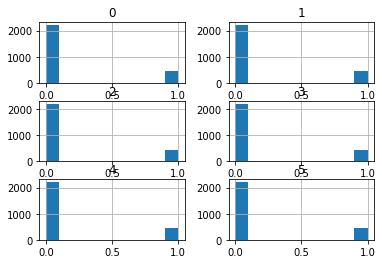

In [31]:
X_train.hist()
y_train.hist()

Make a correlation matrix

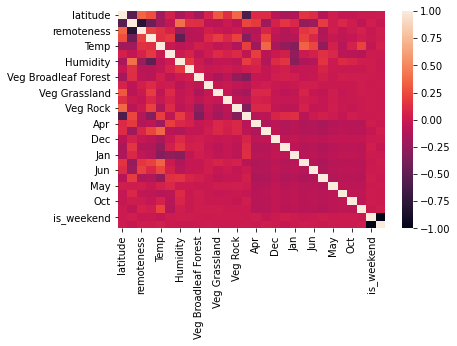

In [32]:
import seaborn as sn

corrMatrix = dfPredictor.corr()
sn.heatmap(corrMatrix)
plt.show()

Training models, each in a cell (?)

* Dummy classifier
* K-Nearest Neighbour (KNN)
* Naïve Bayes (NB)
* Support Vector Machine (SVM)
* Decision Tree (DT)
* Random Forest (RF)
* Gradient Boosted Trees (GBT)
* Multi-Layered Perceptron (MLP)
* Artificial Neural Network (ANN)

Evaluation with confusion matrix, F1 score, etc

### Dummy classifier

In [35]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")

dummy_clf.fit(X_train, y_train)
training_accuracy = dummy_clf.score(X_train, y_train)
test_accuracy = dummy_clf.score(X_test, y_test)
print(f"Training accuracy: {training_accuracy}")  # 0.6537796074219915
print(f"Test accuracy: {test_accuracy}")  # 0.6502013422818792


Training accuracy: 0.06575963718820861
Test accuracy: 0.06657718120805368


### KNN

Trained in in 8.7540 seconds


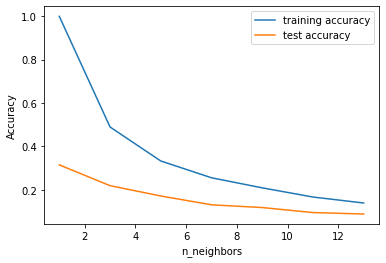

In [36]:
from sklearn.neighbors import KNeighborsClassifier
import time  # optional for timing the code

training_accuracy = []
test_accuracy = []
nNeighbors = range(1, 15, 2)

tic = time.perf_counter()  # timing start
for nNeighbor in nNeighbors:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=nNeighbor, n_jobs=-1)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
toc = time.perf_counter()  # timing end
print(f"Trained in in {toc - tic:0.4f} seconds")  # print the time elapsed

plt.plot(nNeighbors, training_accuracy, label="training accuracy")
plt.plot(nNeighbors, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

9 seems to be the best on our test set. Let's train that model and save it.

In [ ]:
clf = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
clf.fit(X_train, y_train)

training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
print("Number of neighbors: 9")
print(f"\nTraining accuracy: {training_accuracy}")  # 0.7298490543523656
print(f"\nTest accuracy: {test_accuracy}")  # 0.6934228187919463

### Naive Bayes

In [ ]:
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

# train a Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
multi_gnb = MultiOutputClassifier(gnb, n_jobs=-1)
multi_gnb.fit(X_train, y_train)
print(f"GaussianNB train score: {multi_gnb.score(X_train, y_train)}")  # 0.21296462024938845
print(f"GaussianNB test score: {multi_gnb.score(X_test, y_test)}")  # 0.21986577181208053
print("\n")


### Support Vector Machine

In [ ]:
import time  # optional for timing the code
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

training_accuracy = []
test_accuracy = []
C = [0.01, 0.1, 0.25, 0.5, 0.75, 1]

tic = time.perf_counter()  # timing start
for c in C:
    svm = SVC(C = c)
    multi_svm = MultiOutputClassifier(svm, n_jobs=-1)
    multi_svm.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(multi_svm.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(multi_svm.score(X_test, y_test))
toc = time.perf_counter()  # timing end
print(f"Trained in in {toc - tic:0.4f} seconds")  # print the time elapsed

plt.plot(C, training_accuracy, label="training accuracy")
plt.plot(C, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Value of C")
plt.legend()

Best seems to be with C = 0.25

Now lets train the final SVM

In [ ]:
svm = SVC(C = 0.25)
multi_svm = MultiOutputClassifier(svm, n_jobs=-1)
multi_svm.fit(X_train, y_train)

print(f"Kernel SVM train score: {multi_svm.score(X_train, y_train)}")  # 0.7018077680329335
print(f"Kernel SVM test score: {multi_svm.score(X_test, y_test)}")  # 0.6977181208053691
print("\n")

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 40]}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, )
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best max_depth is 5 -->  0.72060144

In [ ]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

print(f"Decision Tree train score: {dt.score(X_train, y_train)}")  # 0.7240618101545254
print(f"Decision Tree test score: {dt.score(X_test, y_test)}")  # 0.7103355704697987
print("\n")

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':[2,4,8,10,11,12,13,14,15,16,20,30,40]}

grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1, warm_start=True), param_grid, cv=5)
grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best seems to be with max_depth=12

In [ ]:
rf = RandomForestClassifier(max_depth=12, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"Random Forest train score: {rf.score(X_train, y_train)}")  # 0.7210786945886284
print(f"Random Forest test score: {rf.score(X_test, y_test)}")  # 0.6877852348993289
print("\n")


### Gradient Boosted Trees (GBT)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier  # (https://sklearn.org/modules/multiclass.html#multioutput-classification)

param_grid = {'estimator__max_depth':[2,4,8,16,30,40], 'estimator__loss':['deviance', 'exponential']}

gbt = MultiOutputClassifier(GradientBoostingClassifier(verbose=0, warm_start=True))
grid_search = GridSearchCV(gbt, param_grid, cv=5)

grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

print('Best parameters found:\n', grid_search.best_params_)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

### Multi-Layered Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(5, 10, 5), (15, 30, 15), (5, 10, 10, 5), (15, 30, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant']
}

grid_search = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, cv=5)

grid_search.fit(X_train, y_train)
scores = grid_search.cv_results_['mean_test_score']
print(scores)

y_true, y_pred = y_test , grid_search.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

print('Best parameters found:\n', grid_search.best_params_)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
